#import kaggle

In [2]:
!pip install kaggle
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 5.3MB 22.9MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 112kB 64.5MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

ref                                                        title                                                size  lastUpdated          downloadCount  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
jessemostipak/hotel-booking-demand                         Hotel booking demand                                  1MB  2020-02-13 01:27:20           4287  
tunguz/big-five-personality-test                           Big Five Personality Test                           159MB  2020-02-17 15:59:37           1201  
arindam235/startup-investments-crunchbase                  StartUp Investments (Crunchbase)                      3MB  2020-02-17 21:54:42           1124  
jamzing/sars-coronavirus-accession                         SARS CORONAVIRUS ACCESSION                            2MB  2020-02-18 15:49:34           1488  
brandenciranni/democratic-debate-transcripts-2020          Democratic 

In [0]:
import zipfile
zipref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zipref.extractall()
zipref.close()

# start

## import data

In [6]:
import imgaug as aug
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.metrics import classification_report
color = sns.color_palette()
%matplotlib inline


Using TensorFlow backend.


In [0]:
# Get directories
# main directory
data_dir = Path('../content/chest_xray/chest_xray')

# train 
train_dir = data_dir / 'train'

# validation
val_dir = data_dir / 'val'

# test
test_dir = data_dir / 'test'

In [25]:
# Get the path to the normal and pneumonia sub-dir
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# (img_path, label) format for data
train_data = []

# normal cases, label 0
for img in normal_cases:
    train_data.append((img,0))

# pneumonia cases, label 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# to dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,../content/chest_xray/chest_xray/train/PNEUMON...,1
1,../content/chest_xray/chest_xray/train/NORMAL/...,0
2,../content/chest_xray/chest_xray/train/NORMAL/...,0
3,../content/chest_xray/chest_xray/train/PNEUMON...,1
4,../content/chest_xray/chest_xray/train/PNEUMON...,1


## plotting

In [26]:
cases = train_data['label'].value_counts()
print(cases)

1    3875
0    1341
Name: label, dtype: int64


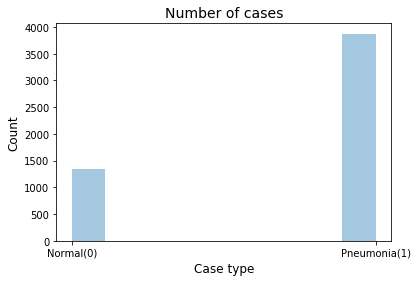

In [27]:
# Plot the results 
sns.distplot(train_data['label'],kde = False)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

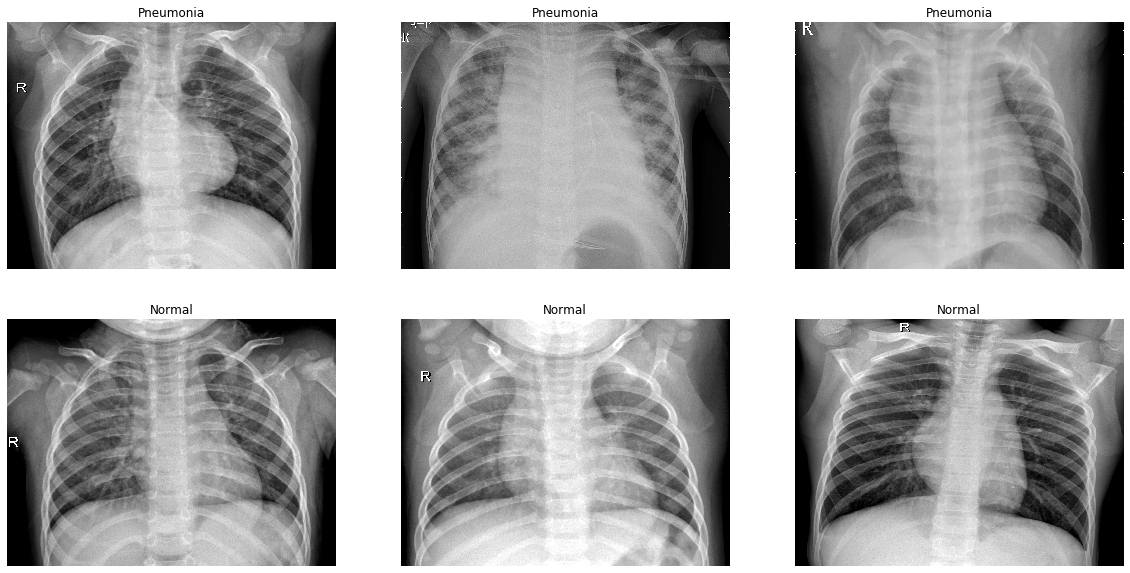

In [28]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:3]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,3, figsize=(20,10))
number_images = 3
for i in range(6):
    img = imread(samples[i])
    ax[i//number_images, i%number_images].imshow(img, cmap='gray')
    if i<number_images:
        ax[i//number_images, i%number_images].set_title("Pneumonia")
    else:
        ax[i//number_images, i%number_images].set_title("Normal")
    ax[i//number_images, i%number_images].axis('off')
    ax[i//number_images, i%number_images].set_aspect('auto')
plt.show()

## preprocessing

In [29]:
# sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels.
# Convert all in 3 channels
# Normalize the pixel values and resizing all the images to 224x224 

# Normal
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia       
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total validation samples : ", valid_data.shape)
print("Total labels:", valid_labels.shape)

Total validation samples :  (16, 224, 224, 3)
Total labels: (16, 2)


In [0]:
# Augmentation
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=10), # rotation
    iaa.LinearContrast((0.75, 1.5)), #contrast
    iaa.Multiply((1, 1.3))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # total nsamples
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for _, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [32]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [33]:
cut = 12

model_vgg16_conv.layers
for i in range(cut):
  model_vgg16_conv.layers.pop();
  
model_vgg16_conv.layers
model_vgg16_conv.summary()

input = Input(shape=(224,224,3),name = 'image_input')
output_vgg16_conv = model_vgg16_conv(input)
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.4, name='dropout1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3, name='dropout2')(x)
x = Dense(206, activation='relu', name='fc3')(x)
x = Dense(2, activation='softmax', name='fc4')(x)
my_model=Model(input=input,output=x)
my_model.summary();

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("fc...)`


In [0]:
opt = Adam(lr=0.0001, decay=1e-4)
es = EarlyStopping(patience=5)
my_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [36]:
batch_size = 20
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 260 and 16


In [37]:
# weights
from sklearn.utils import class_weight
print(np.unique(train_data['label']))
train_weight = class_weight.compute_class_weight('balanced', np.unique(train_data['label']),train_data['label'])
train_weights = dict(enumerate(train_weight, start = 0))
print(train_weights)

[0 1]
{0: 1.9448173005219984, 1: 0.6730322580645162}


In [38]:
# Fit the model
 history = my_model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es],
                               class_weight=train_weights)

Epoch 1/20
260/260 [==============================] - 100s 385ms/step - loss: 0.2550 - acc: 0.8944 - val_loss: 0.0777 - val_acc: 0.9375
Epoch 2/20
260/260 [==============================] - 83s 318ms/step - loss: 0.1319 - acc: 0.9515 - val_loss: 0.1357 - val_acc: 0.9375
Epoch 3/20
260/260 [==============================] - 87s 333ms/step - loss: 0.1133 - acc: 0.9588 - val_loss: 0.2026 - val_acc: 0.8750
Epoch 4/20
260/260 [==============================] - 84s 322ms/step - loss: 0.0763 - acc: 0.9765 - val_loss: 0.0828 - val_acc: 1.0000
Epoch 5/20
260/260 [==============================] - 82s 315ms/step - loss: 0.0675 - acc: 0.9800 - val_loss: 0.0433 - val_acc: 1.0000
Epoch 6/20
260/260 [==============================] - 82s 315ms/step - loss: 0.0765 - acc: 0.9769 - val_loss: 0.0593 - val_acc: 1.0000
Epoch 7/20
260/260 [==============================] - 81s 312ms/step - loss: 0.0707 - acc: 0.9827 - val_loss: 0.0722 - val_acc: 0.9375
Epoch 8/20
260/260 [==============================] - 

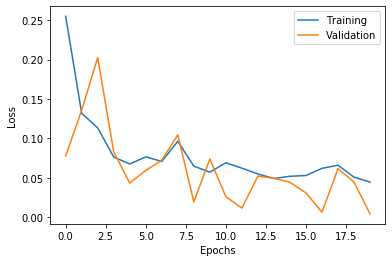

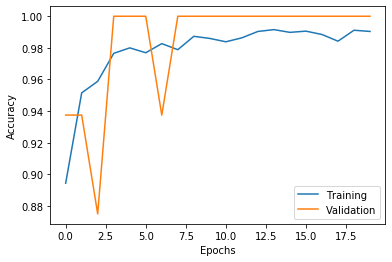

In [39]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

In [40]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [41]:
# predictions
preds = my_model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)


orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

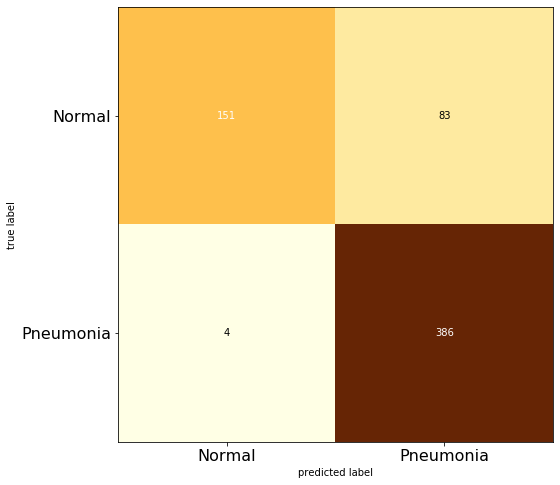

In [42]:
# confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.YlOrBr)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [43]:
# evaluation
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

